In [1]:
from __future__ import division
%matplotlib inline
import cPickle
import datetime
from dateutil import parser
import itertools
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.integrate import quadrature, romberg
from scipy.interpolate import interp1d
from scipy.special import legendre
from tqdm import tqdm_notebook

# Load the sunphotometer data

In [2]:
def parseSunPhotoMeter(path, usecols):
    """Parse the sunphotometer data."""

    def dateparse(d, t):
        return pd.datetime.strptime(d+' '+t, '%d:%m:%Y %H:%M:%S')

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=usecols
    )

    wavelengths = [float(i.split("[")[0]) for i in df.columns]
    df = df.rename(index=str, columns=dict(itertools.izip(df.columns, wavelengths)))

    return df, wavelengths

In [3]:
pfn_path = r"../../data/phase_functions/170422_170422_Technion_Haifa_IL.pfn"
df_441, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(3, 86))
)
df_674, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(86, 169))
)
df_871, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(169, 252))
)
df_1020, wavelengths = parseSunPhotoMeter(
    pfn_path,
    usecols=[0, 1]+list(range(252, 335))
)

# Show one of the phase functions

In [14]:
df_441.index

Index([u'2017-04-22 04:19:15', u'2017-04-22 04:43:21', u'2017-04-22 05:33:17',
       u'2017-04-22 06:40:30', u'2017-04-22 12:40:33', u'2017-04-22 13:48:00',
       u'2017-04-22 14:38:13', u'2017-04-22 15:12:46'],
      dtype='object', name=u'Date(dd-mm-yyyy)_Time(hh:mm:ss)')

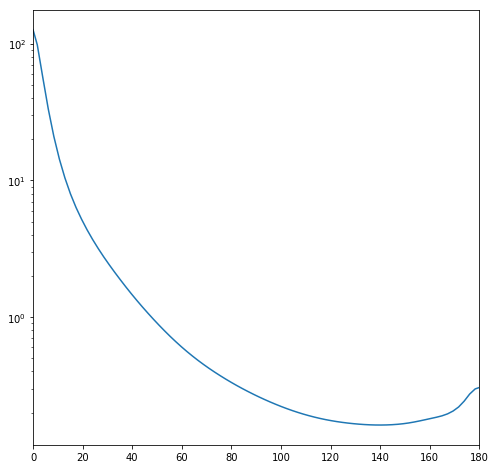

In [40]:
ax = df_871.iloc[3].transpose().plot(logy=True)

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from the sunphotometer gives:

In [42]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_871.iloc[3].values[::-1]
np.trapz(phase, mu)

2.0282637924356193

# Calculate the Legendre Coefficients

## Use quadrature integration

In [43]:
COFFES_NUM = 300

In [44]:
phase_interp = interp1d(mu, phase)

def func(x, lg):
    return (2*l + 1)/2. * lg(x)*phase_interp(x)

coeffs_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l)
    coeffs_quad.append(quadrature(func, -1, 1, args=(lg,), maxiter=1000, )[0])

C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.337720e-06
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.269579e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.435147e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.778666e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 3.127794e-05
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:196: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 

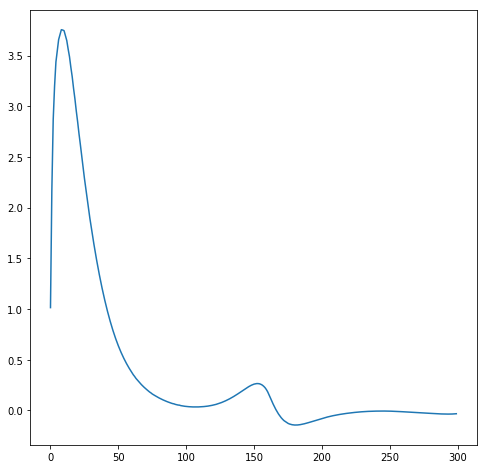

In [46]:
plt.plot(coeffs_quad)

In [47]:
mu_new = np.linspace(-1, 1, 300)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff

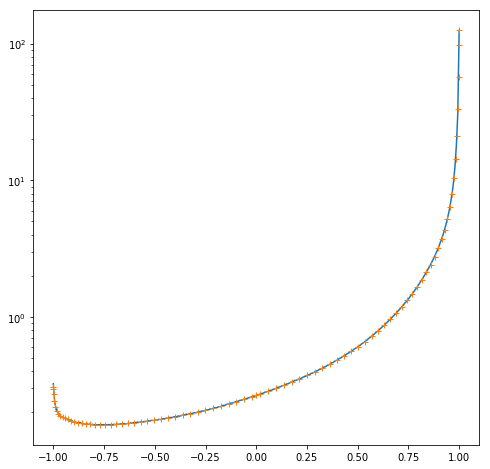

In [48]:
plt.semilogy(mu_new, phase_gauss)
plt.semilogy(mu, phase, '+')

In [49]:
np.save("phase_871.npy", np.array(coeffs_quad))

## Test with Henyey-Greenstein function

p(µ) = 1
2
1 − g
2
[1 + g
2 − 2g µ ]
3/2


In [69]:
COFFES_NUM = 100

In [70]:
def hg(mu, g):
    ph = (1/2)*(1-g**2)/(1+g**2-2*g*mu)**(1.5)
    return ph

def func(mu, l, g):
    return (2*l + 1)/2. * legendre(l)(mu)*hg(mu, g)

G=0.7
coeffs_hg_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    coeffs_hg_quad.append(quadrature(func, -1, 1, args=(l, G), maxiter=200, )[0])

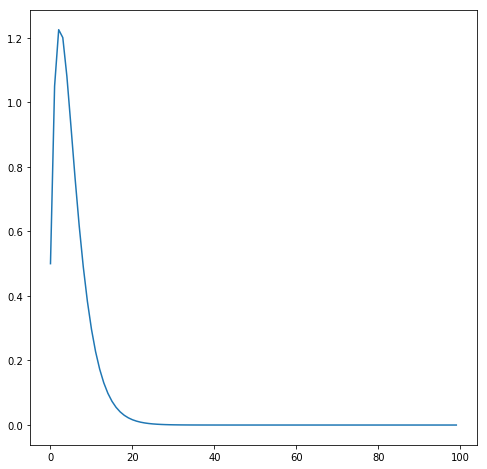

In [71]:
plt.plot(coeffs_hg_quad)

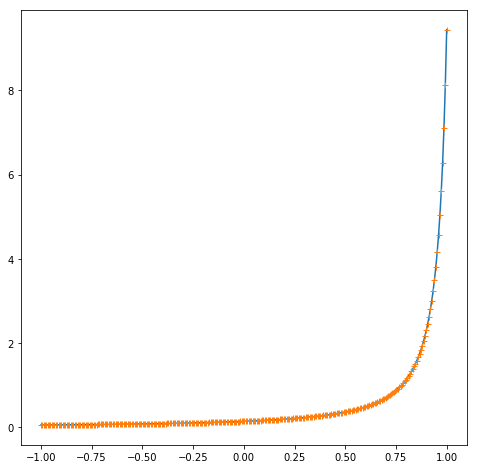

In [72]:
mu_new = np.linspace(-1, 1, 300)
phase_hg = 0
for l, coeff in enumerate(coeffs_hg_quad):
    phase_hg += legendre(l)(mu_new) * coeff
plt.plot(mu_new, phase_hg)
real_hg = [hg(m, G) for m in mu_new]
plt.plot(mu_new, real_hg, '+')

## Test with a single coefficient function

In [65]:
COFFES_NUM = 100
LG = 1

In [66]:
def lg(mu, l):
    return legendre(l)(mu)

def func(mu, l, l2):
    return (2*l + 1)/2. * legendre(l)(mu)*lg(mu, l2)

coeffs_lg_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    coeffs_lg_quad.append(quadrature(func, -1, 1, args=(l, LG), maxiter=200, )[0])

(0, 10)

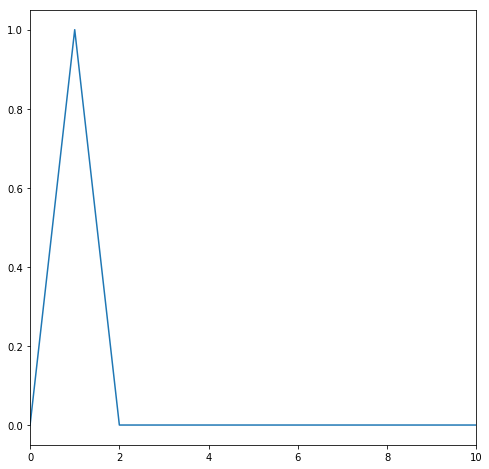

In [67]:
plt.plot(coeffs_lg_quad)
plt.xlim(0, 10)

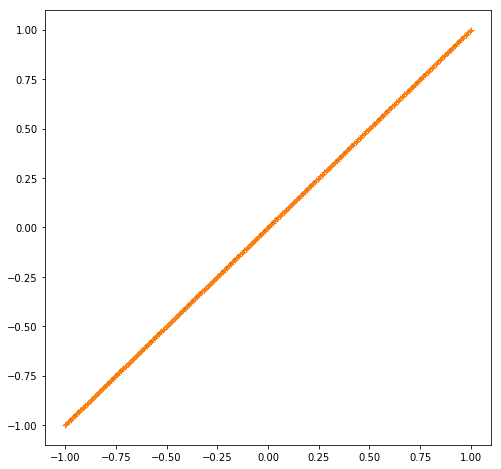

In [68]:
mu_new = np.linspace(-1, 1, 300)
phase_lg = 0
for l, coeff in enumerate(coeffs_lg_quad):
    phase_lg += legendre(l)(mu_new) * coeff
plt.plot(mu_new, phase_lg)
real_lg = [lg(m, LG) for m in mu_new]
plt.plot(mu_new, real_lg, '+')

## Use trapezoidale integration

Note that at coefficient 86 we get some warning. P_86 has occilations at about the sampleing frequency of the data (180 degrees / 2 degrees between samples). See the graph below.

In [6]:
coeffs_trapz = []
for l in range(86):
    coeffs_trapz.append((2*l + 1)/2. * np.trapz(legendre(l)(mu)*phase, mu))

In [7]:
mu_new = np.linspace(-1, 1, 300)
phase_trapz = legendre(0)(mu_new) * coeffs_trapz[0]
for l, coeff in enumerate(coeffs_trapz[1:]):
    phase_trapz += legendre(l)(mu_new) * coeff

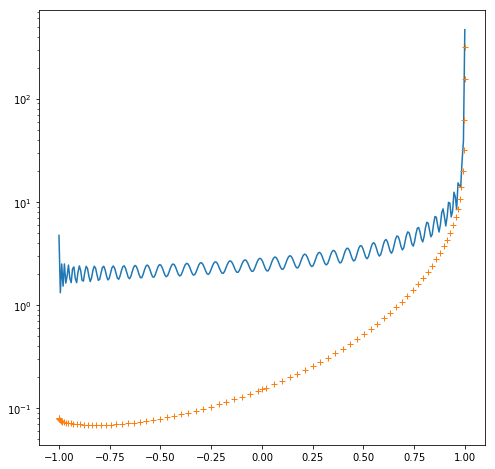

In [8]:
plt.semilogy(mu_new, phase_trapz)
plt.semilogy(mu, phase, '+')

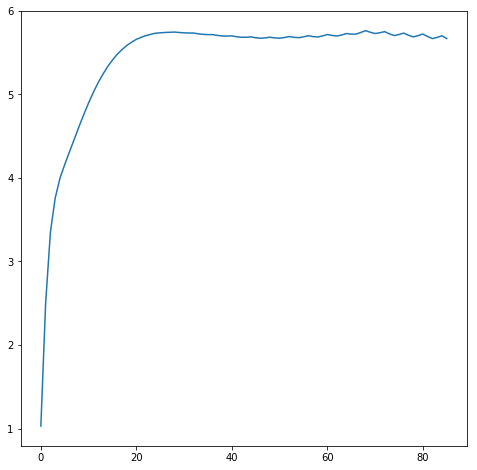

In [9]:
plt.plot(coeffs_trapz)

In [10]:
coeffs_trapz[0]

1.0301850781945259

## Use romberg integration

In [11]:
COFFES_NUM = 300

In [15]:
phase_interp = interp1d(mu, phase)

def func(x, l):
    return (2*l + 1)/2. * legendre(l)(x)*phase_interp(x)

coeffs_romberg = []
for l in tqdm_notebook(range(COFFES_NUM)):
    coeffs_romberg.append(romberg(func, -1, 1, args=(l,), vec_func=True))

C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.359110e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\special\orthogonal.py:145: RuntimeWarning: invalid value encountered in multiply
  self.__dict__['coeffs'] *= kn
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.319771e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.280286e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.227783e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.175210e+01
  AccuracyWa

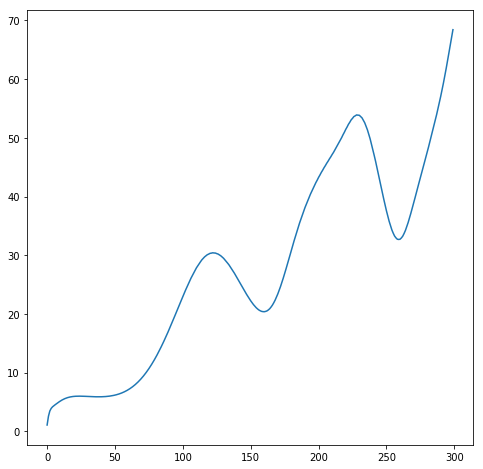

In [16]:
plt.plot(coeffs_romberg)

In [17]:
mu_new = np.linspace(-1, 1, 300)
phase_gauss = legendre(0)(mu_new) * coeffs_romberg[0]
for l, coeff in enumerate(coeffs_romberg[1:]):
    phase_gauss += legendre(l)(mu_new) * coeff

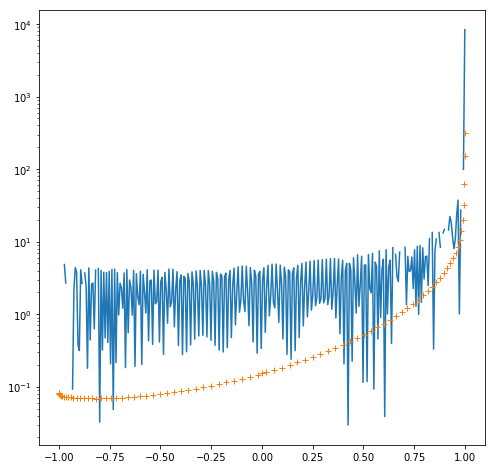

In [18]:
plt.semilogy(mu_new, phase_gauss)
plt.semilogy(mu, phase, '+')